In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors


# File Loading

In [2]:
training = "first_combined_training"
#training = "first_wc_training"

In [3]:
print("loading all_df.pkl...")
with open(f"../intermediate_files/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(747332, 102)
loading predictions.pkl...
pred_df.shape=(71178, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(35589, 120)
presel_merged_df.shape=(24065, 120)


,wc_kine_reco_Enu,wc_match_isFC,wc_nc_pio_score,wc_nc_delta_score,wc_numu_score,wc_nue_score,wc_shw_sp_n_20mev_showers,wc_truth_NprimPio,wc_truth_NCDelta,wc_reco_nuvtxX,...,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_2g_outFV,prob_1eNp,prob_1e0p,prob_0g,prob_3plusg,prob_dirt,prob_ext
0,614.294678,True,3.510125,-3.342609,-0.445759,-15.000000,2.0,1.0,0.0,235.407227,...,0.021713,0.028007,0.004797,0.000928,0.000130,0.000055,0.011652,0.006953,0.000425,0.002590
1,563.121155,True,3.168464,-6.305526,-0.906318,-8.405992,3.0,1.0,0.0,156.138885,...,0.011109,0.033482,0.002596,0.000183,0.000089,0.000072,0.005161,0.008011,0.000212,0.001270
4,419.250702,False,5.160080,-7.236095,-1.000641,-9.779932,2.0,1.0,0.0,144.645752,...,0.884811,0.014763,0.001280,0.001753,0.000053,0.000118,0.006237,0.001620,0.000256,0.000505
5,504.538116,True,2.628025,1.638694,-0.130912,-15.000000,1.0,1.0,0.0,79.231628,...,0.057308,0.012016,0.002496,0.000329,0.000098,0.000091,0.057042,0.004887,0.000404,0.001121
7,417.981934,False,2.573358,-3.236898,-0.727442,-13.695713,2.0,1.0,0.0,95.053276,...,0.444659,0.015923,0.004726,0.008910,0.000212,0.000188,0.003367,0.005392,0.001285,0.004950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745925,334.598816,False,-3.512204,-3.114151,-0.032794,-15.000000,1.0,NaN,NaN,60.771526,...,0.000747,0.008671,0.000543,0.000134,0.000112,0.000104,0.699227,0.000160,0.020852,0.260241
746371,101.547508,True,-0.807734,-1.905209,-0.938013,-15.000000,1.0,NaN,NaN,51.878151,...,0.006257,0.000793,0.000267,0.000738,0.000150,0.000139,0.149612,0.000367,0.561956,0.261371
746558,184.437103,False,-0.041014,-4.554944,-3.454599,-15.000000,1.0,NaN,NaN,107.533432,...,0.001196,0.000233,0.000097,0.000114,0.000057,0.000052,0.038569,0.000080,0.278648,0.658862
746934,542.516235,True,-4.388559,-5.872269,-0.014429,-15.000000,1.0,NaN,NaN,145.772400,...,0.003884,0.001416,0.000935,0.000148,0.000127,0.000116,0.227241,0.000238,0.014188,0.744927


In [4]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_78356/4263806371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Multi-Class Histograms

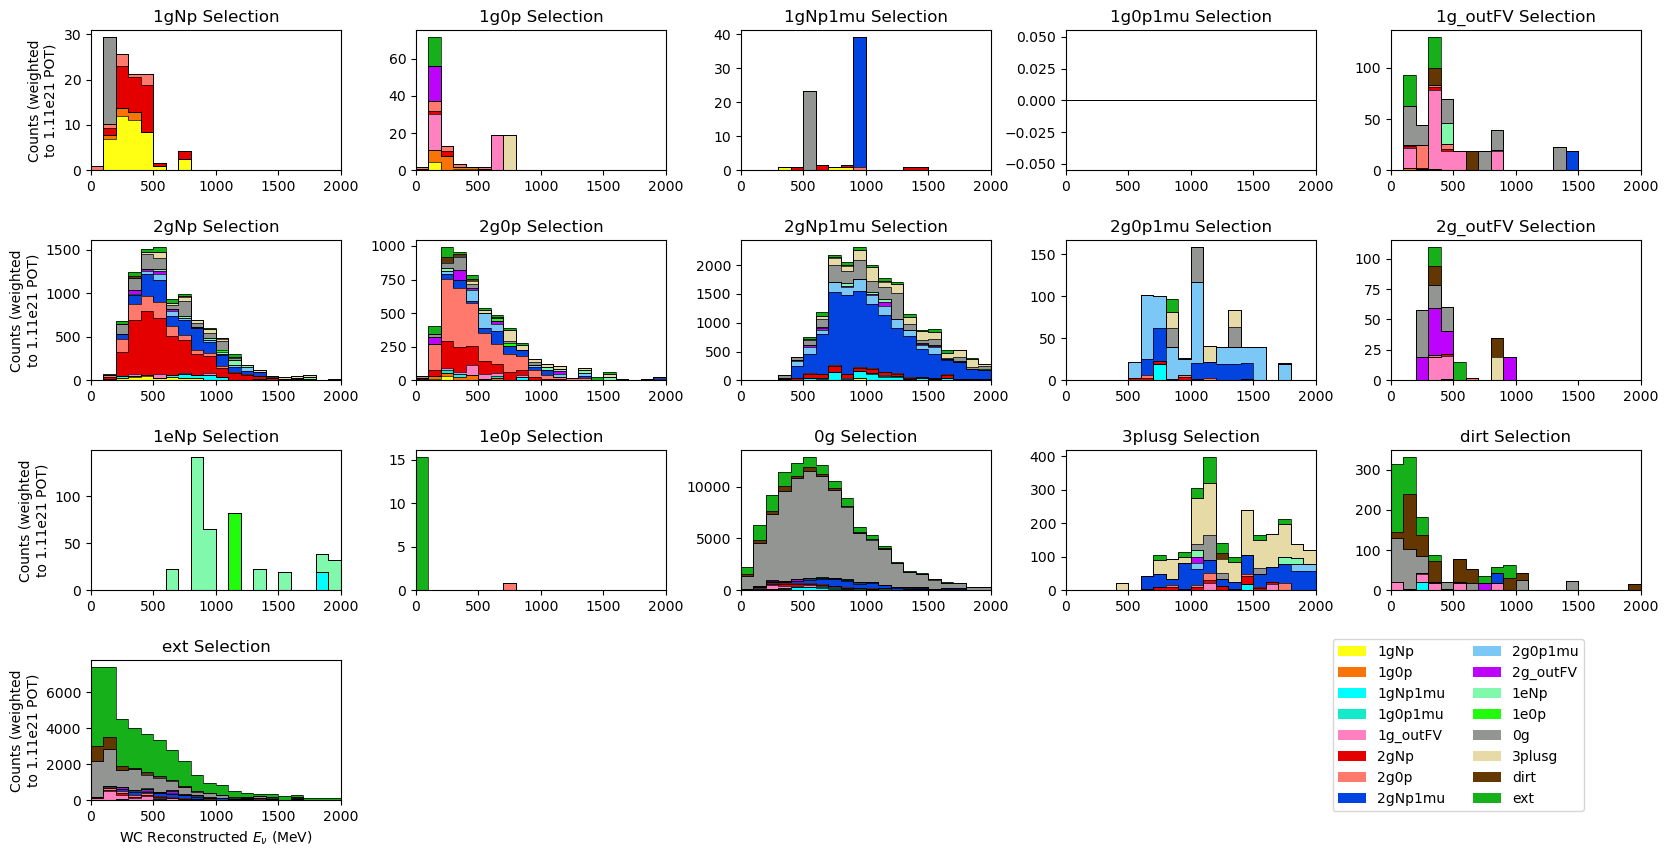

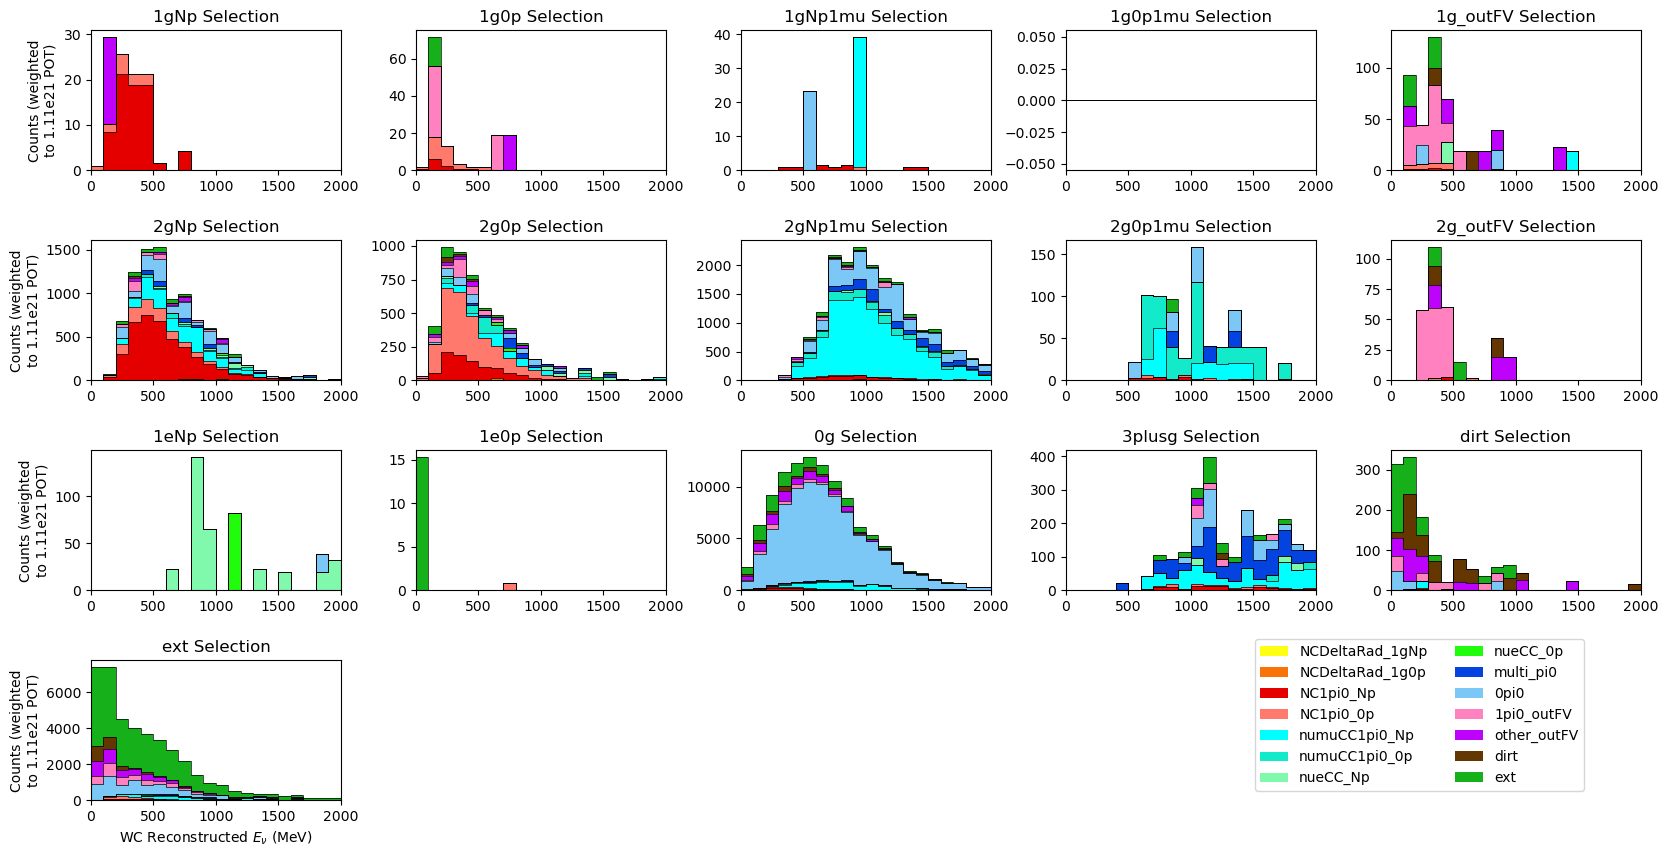

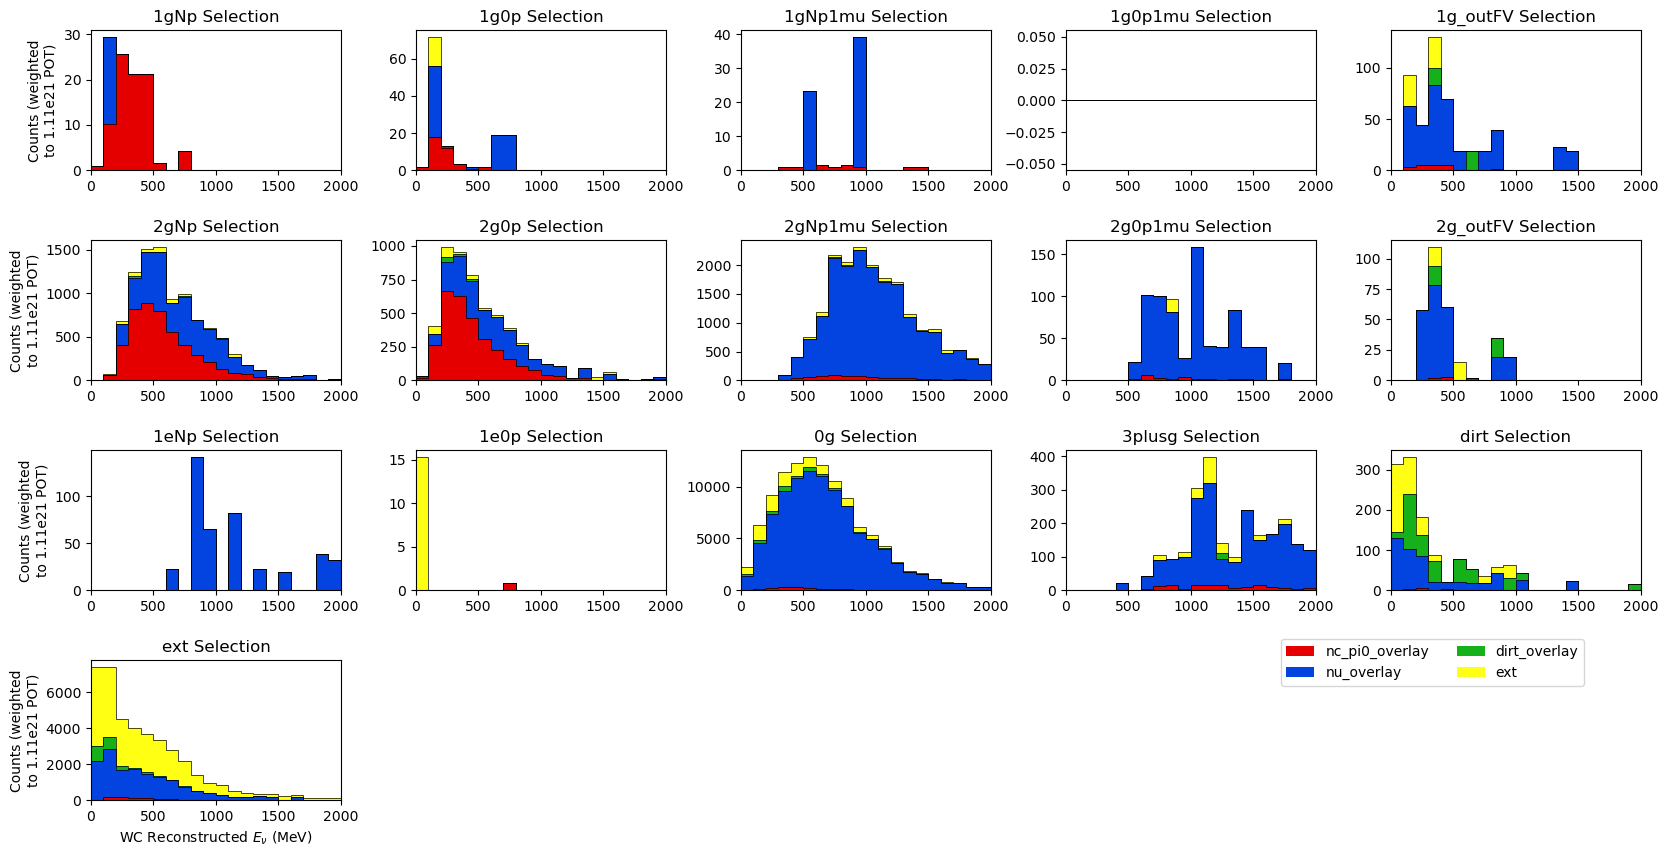

In [5]:
reco_category_queries = []
for i, signal_category in enumerate(sig_categories):
    reco_category_queries.append(f"reco_category_argmax_index == {i}")
    
for breakdown_type in ["topological", "physics", "filetype"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)

    for i, signal_category in enumerate(sig_categories):

        sel_df = presel_merged_df.query(reco_category_queries[i])

        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])

        axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
        
        if i >= 15: # Only show x-label for bottom row
            axs[i].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        if i % 5 == 0: # Only show y-label for leftmost column
            axs[i].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
        axs[i].set_title(f"{signal_category} Selection")
        axs[i].set_xlim(0, 2000)
        
        if i == 15:
            axs[i].legend(ncol=2, loc='upper right', bbox_to_anchor=(6, 1.2))

    axs[16].remove()
    axs[17].remove()
    axs[18].remove()
    axs[19].remove()

    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}.pdf")


# Checking Event Weights

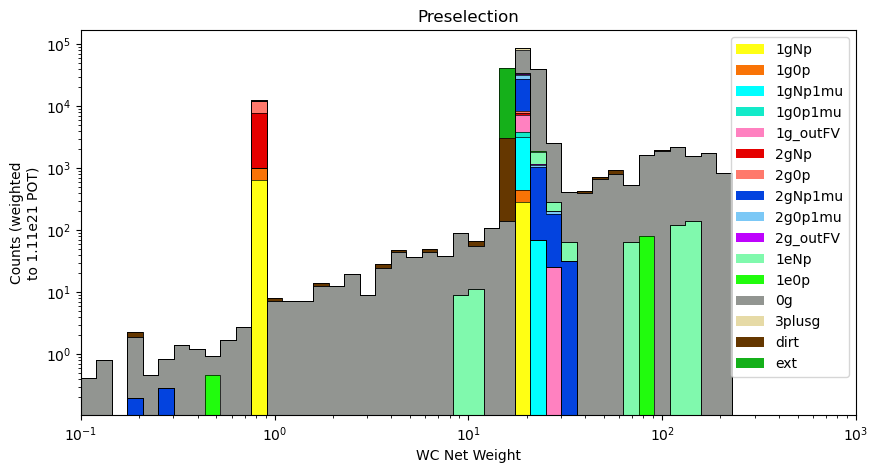

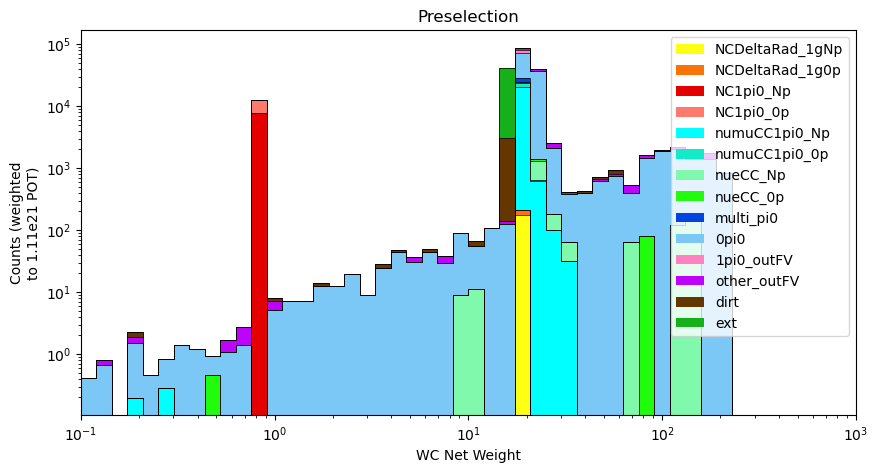

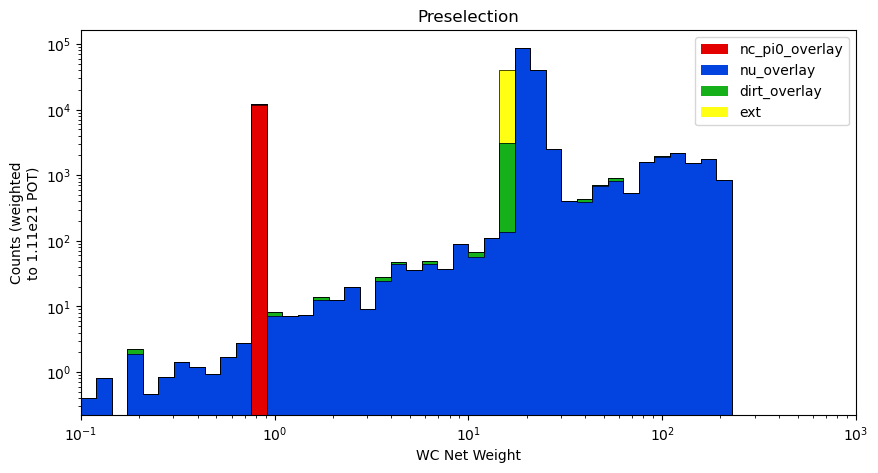

In [6]:
for breakdown_type in ["topological", "physics", "filetype"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    plt.figure(figsize=(10, 5))

    bins = np.logspace(-1, 3, 51)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)

    sel_df = presel_merged_df
    counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = sel_df.query(breakdown_queries[breakdown_i])
        counts.append(np.histogram(curr_df["wc_net_weight"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

    plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
    plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)

    plt.xlabel(r"WC Net Weight")
    plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="upper right")
    plt.title("Preselection")
    plt.show()



# Post-Selection Studies

In [7]:
one_g_reco_category_argmax_indices = []
for i, signal_category in enumerate(sig_categories):
    if "1g" in signal_category:
        one_g_reco_category_argmax_indices.append(i)

combined_1g_query = ""
for i in one_g_reco_category_argmax_indices:
    combined_1g_query += f"reco_category_argmax_index == {i} or "
combined_1g_query = combined_1g_query[:-4]

all_1g_sel_df = presel_merged_df.query(combined_1g_query)

print(len(presel_merged_df))
print(len(all_1g_sel_df))

24065
221


## Blip Veto

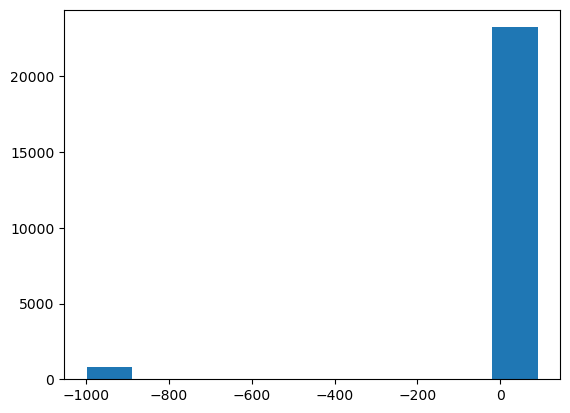

In [8]:
plt.hist(np.nan_to_num(presel_merged_df["blip_closest_upstream_angle"], nan=-999))
plt.show()

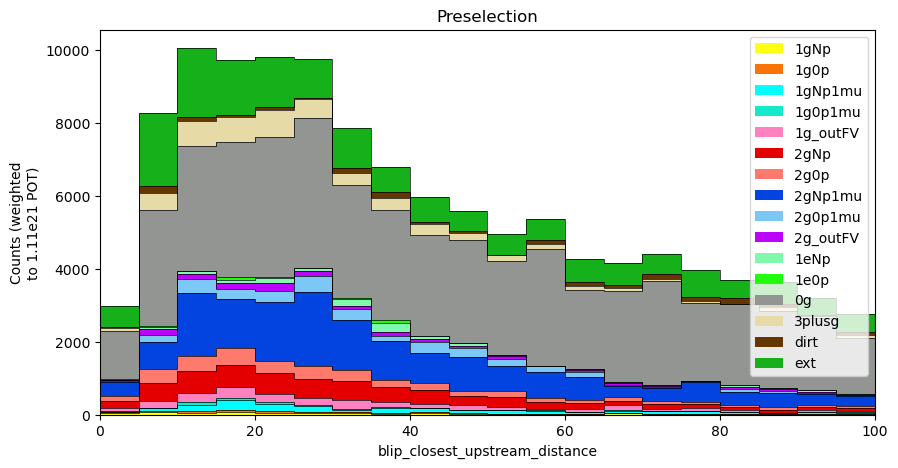

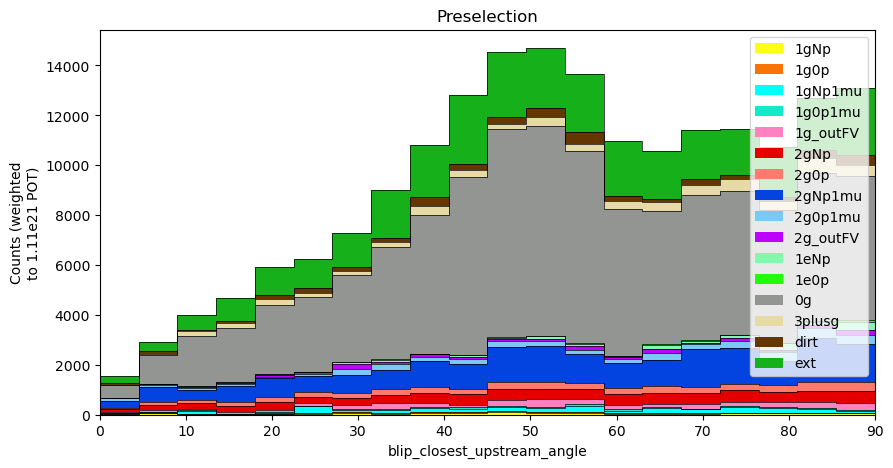

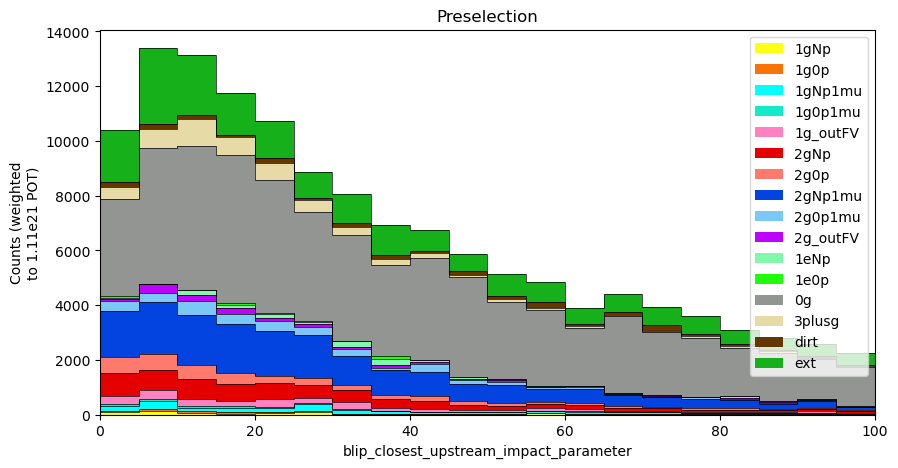

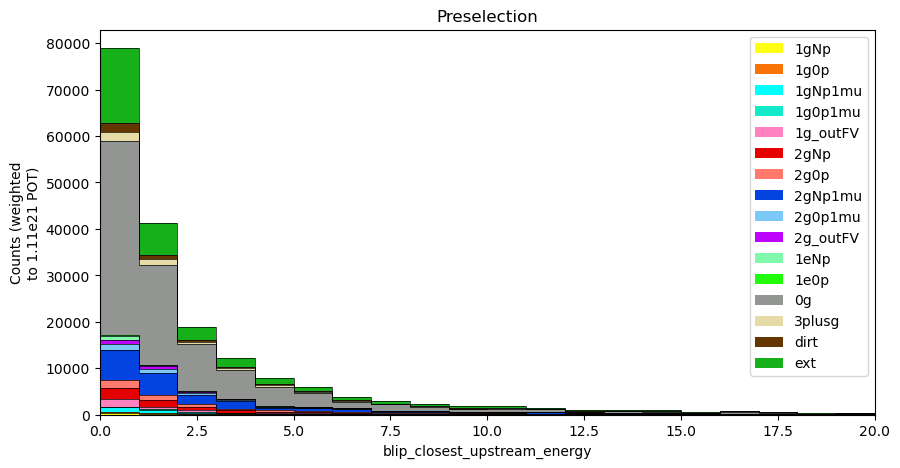

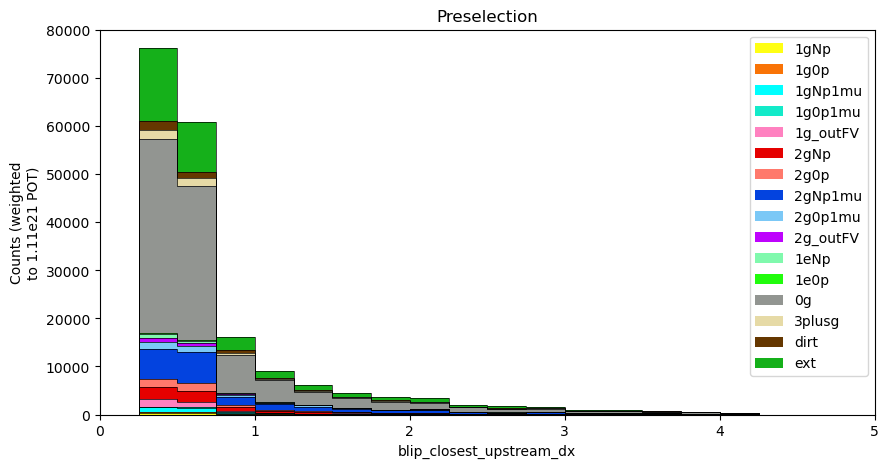

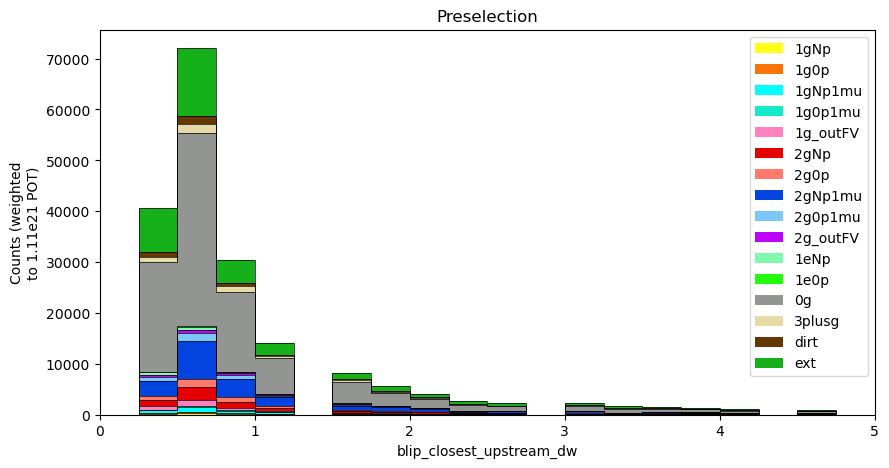

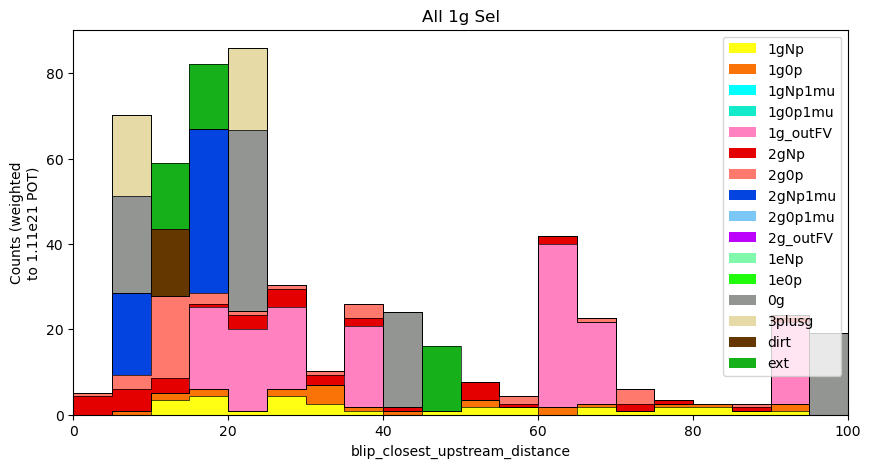

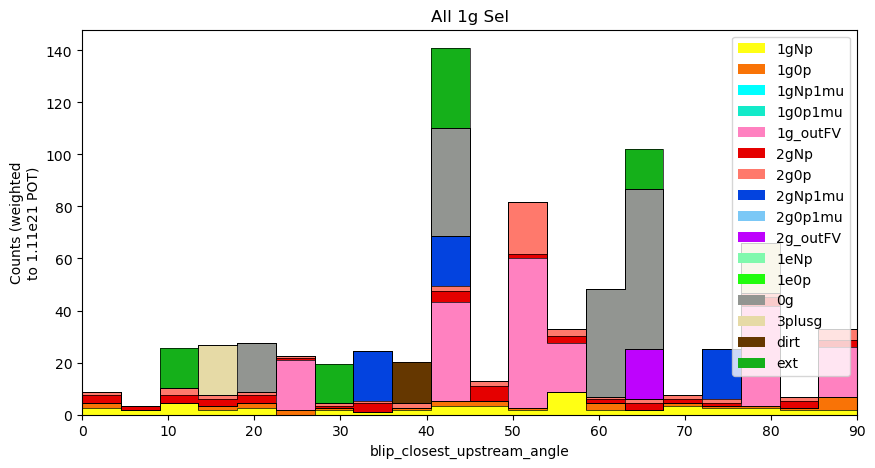

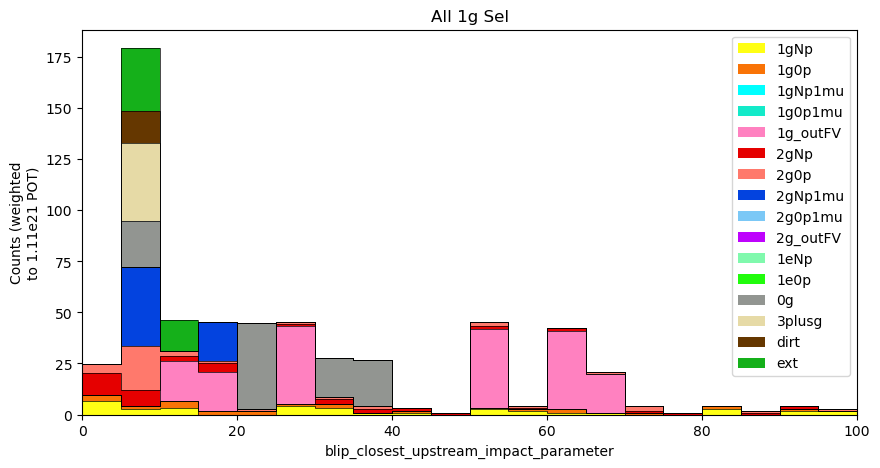

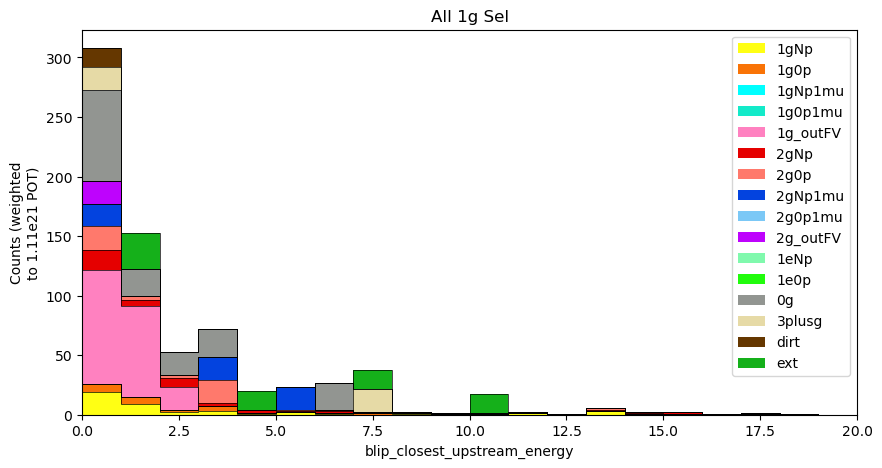

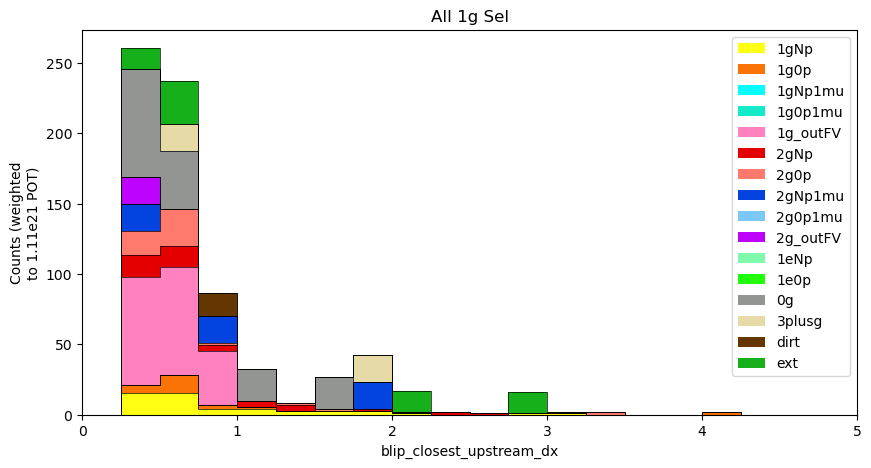

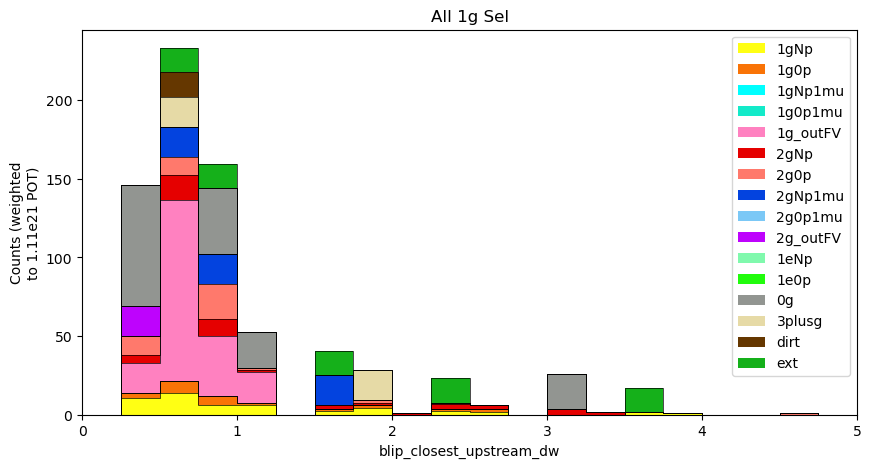

In [9]:
for breakdown_type in ["topological"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df
                
        blip_postprocessing_vars_bin_ranges = [
            ("blip_closest_upstream_distance", 0, 100),
            ("blip_closest_upstream_angle", 0, 90),
            ("blip_closest_upstream_impact_parameter", 0, 100),
            ("blip_closest_upstream_energy", 0, 20),
            ("blip_closest_upstream_dx", 0, 5),
            ("blip_closest_upstream_dw", 0, 5),
        ]

        for var, min_val, max_val in blip_postprocessing_vars_bin_ranges:

            plt.figure(figsize=(10, 5))
            bins = np.linspace(min_val, max_val, 21)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            multi_bin_centers = [bin_centers] * len(breakdown_labels)
            outline_colors = ["k"] * len(breakdown_labels)
            counts = []
            for breakdown_i, breakdown_label in enumerate(breakdown_labels):
                curr_df = sel_df.query(breakdown_queries[breakdown_i])
                counts.append(np.histogram(curr_df[var].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
            plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
            plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
            plt.xlabel(var)
            plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
            plt.xlim(bins[0], bins[-1])
            plt.legend(loc="upper right")
            if sel_type == "presel":
                plt.title(f"Preselection")
            else:
                plt.title(f"All 1g Sel")
            plt.show()


## Nanosecond Timing

## Out-TPC PMT Veto

In [10]:
# TODO: https://github.com/kpulido444/REU_uboone_photon_rejection

# Could require SUPRPRISE files with newer WC PMT info


## Spacepoint SSV

In [11]:
# TODO: https://github.com/leehagaman/spacepoint_ssv
# Will require processing ntuples with all cosmic spacepoints turned on
